<a href="https://colab.research.google.com/github/tburger101/Late-Swap/blob/main/late_swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

## **Loading and transforming data**

In [4]:
'''Load the data from the 2019 and 2020 season'''

df_2019=pd.read_csv("/content/2019_late_swap_history.csv")
df_2020=pd.read_csv("/content/2020_late_swap_history.csv")
df=pd.concat([df_2019, df_2020])

In [5]:
'''Create predicted rank bins so it is easier to analyze by segment'''

df['pred_rank_bin']=pd.cut(df['pred_perc'], [(x*5)/100 for x in range (0,5)])
df['final_rank_bin']=pd.cut(df['actual_perc'], [(x)/100 for x in range (0,101)])

## **Data Exploration**

In [6]:
'''Breakdown by percentage of where the Top 10 actual finishers are predicted to finish after the morning games.
84% of top 10 finishers come from pred rank of 0-.5%.'''

df[df['final_rank']<=10].groupby('pred_rank_bin')['entry_id'].count()/len(df[df['final_rank']<=10])
#a.plot.bar(figsize=(10,5))

pred_rank_bin
(0.0, 0.05]    0.840909
(0.05, 0.1]    0.068182
(0.1, 0.15]    0.038961
(0.15, 0.2]    0.029221
Name: entry_id, dtype: float64

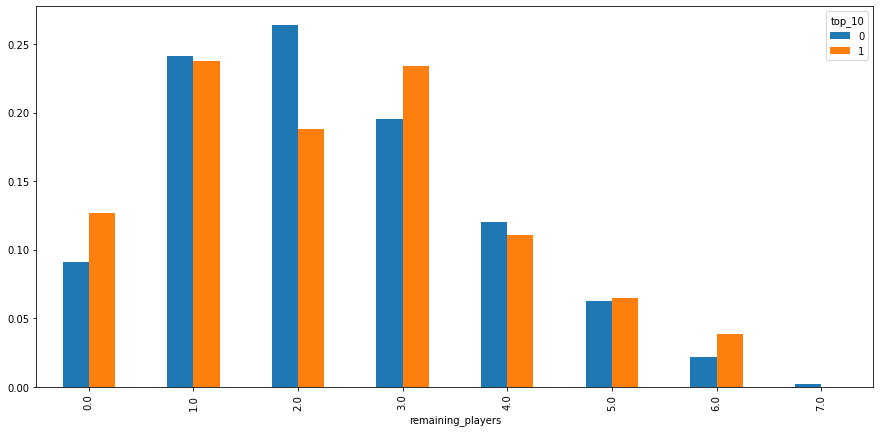

In [9]:
'''Breakdown of how players remaining affect the likelihood of a top 10 finish in the top 5 predicted percent.'''

top_5=df[(df['pred_perc']<=.05) ]
pd.crosstab(columns=top_5['top_10'], index=top_5['remaining_players'], 
            values='entry_id', aggfunc='count', normalize='columns').plot.bar(figsize=(15,7))

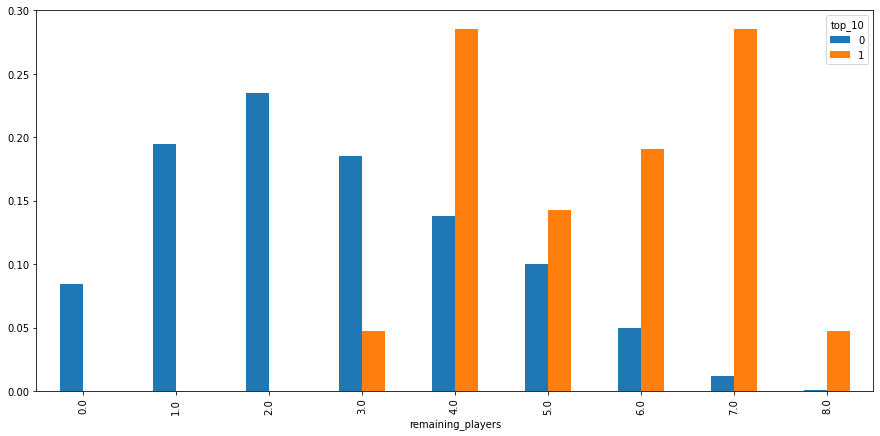

In [8]:
'''Breakdown of how players remaining affect the likelihood of a top 10 finish in the top 5 predicted percent.'''

top_5=df[(df['pred_perc']>.05) & (df['pred_perc']<=.10)]
pd.crosstab(columns=top_5['top_10'], index=top_5['remaining_players'], 
            values='entry_id', aggfunc='count', normalize='columns').plot.bar(figsize=(15,7))

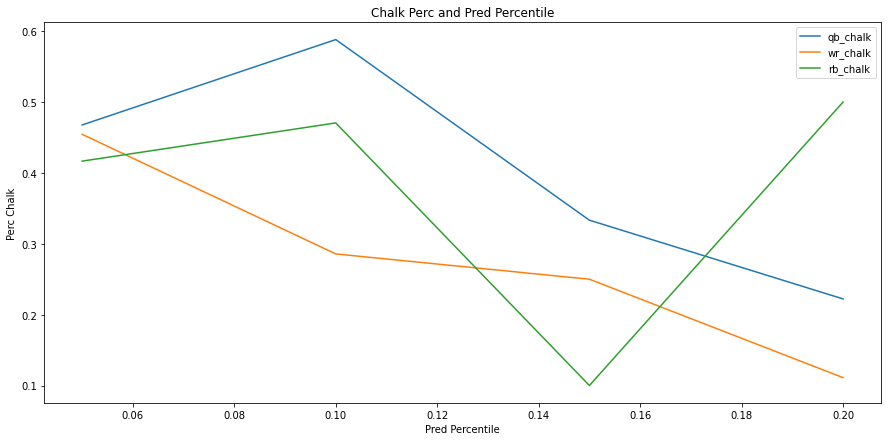

In [15]:
'''How often was the chalk played in the afternoon games of the Top 10 Finishers and where they stood after the morning slate of games'''

import matplotlib.pyplot as plt
''' To get in the top .1% as your team starts slower you have to get different in order to get there'''
qb_chalk=df[(df['top_10']==1)& ((df['qbs']==1)) ].groupby('pred_rank_bin')['chalk_qb'].mean()
wr_chalk=df[(df['top_10']==1)& ((df['wrs']>=1)) ].groupby('pred_rank_bin')['chalk_wr'].mean()
rb_chalk=df[(df['top_10']==1)& ((df['rbs']>=1))].groupby('pred_rank_bin')['chalk_rb'].mean()

plt.figure(figsize=(15,7))
plt.plot([.05, .1, .15, .2],qb_chalk.values,  label = "qb_chalk")
plt.plot([.05, .1, .15, .2],wr_chalk.values,  label = "wr_chalk")
plt.plot([.05, .1, .15, .2],rb_chalk.values, label = "rb_chalk")

plt.ylabel('Perc Chalk')
plt.xlabel('Pred Percentile')
plt.title('Chalk Perc and Pred Percentile')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

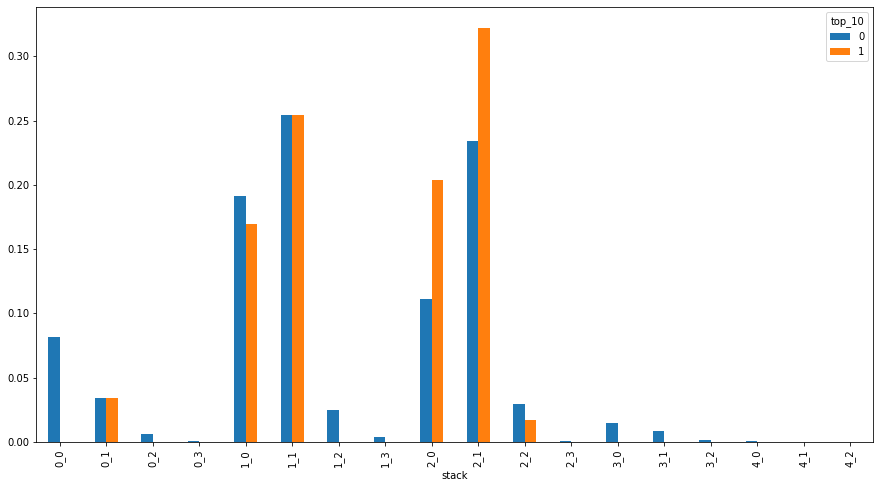

In [46]:
'''Optimal stack construction for top top 5 predicted percent'''

qb_df=df[(df['pred_perc']<=.05) & (df['qbs']==1) & (df['remaining_players']>=3)]
pd.crosstab(columns=qb_df['top_10'], index=qb_df['stack'],
            values='entry_id', aggfunc='count', normalize='columns').plot.bar(figsize=(15, 8))

## **Data Pre-Processing**

In [17]:
def numerical_cat_variables(df):
    '''
    Input: DataFrame
    Outputs: A list of category columns vs list of numerical columns
    
    '''
    numerical=[]
    cat=[]
    for column, data_type in zip(df.columns, df.dtypes):
        if data_type=='object' or data_type=='uint8':
            cat.append(column)
        else:
            numerical.append(column)
    return(cat, numerical)

In [29]:
'''
Narrowing down to useful columns and check for null values
'''
final_df=df[['salary_remaining', 'pred_perc', 'chalk_rb', 'chalk_wr', 'chalk_te', 'chalk_qb', 
'qbs', 'rbs', 'wrs', 'te', 'qb_stack',	'qb_opp_stack', 'top_10']]

final_df.count()/final_df.shape[0]

salary_remaining    0.998896
pred_perc           0.998896
chalk_rb            1.000000
chalk_wr            1.000000
chalk_te            1.000000
chalk_qb            1.000000
qbs                 1.000000
rbs                 1.000000
wrs                 1.000000
te                  1.000000
qb_stack            1.000000
qb_opp_stack        1.000000
top_10              1.000000
dtype: float64

In [31]:
'''
Removing rows with N/As
'''
final_df.dropna( how="any", inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [32]:
'''
Breaking the final dataframe up into training and testing sets
'''

y=final_df['top_10']
x=final_df.drop('top_10', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [33]:
'''
We created a column transformer used to scale numerical columns in our pipeline.  Used below site for reference:
https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/
'''

cat_variables, num_variables=numerical_cat_variables(x)
t = [('num', StandardScaler(), num_variables)]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')

## **Modeling**

In [34]:
'''
Preparing a gridsearch parameters to optimize best model
'''

pipeline=Pipeline([('t', col_transform), ('clf', RandomForestClassifier(class_weight='balanced', n_jobs=-1))])
dec_param_grid = { "clf__max_depth": [2,3,4],  "clf__n_estimators": [10, 50, 100],
                 "clf__max_features": ['auto','log2']}
clf_grid=GridSearchCV(pipeline, param_grid=dec_param_grid, scoring='roc_auc', n_jobs=-1, cv=3)

In [35]:
'''
Fitting the gridsearch model and finding the best estimator
'''

clf_grid.fit(x_train,y_train)
clf=clf_grid.best_estimator_

In [36]:

'''
The top 20 most important features
'''

importances=clf[1].feature_importances_
feature_importances=[]
for column, feature in zip(x_train.columns, importances):
    feature_importances.append([column, feature])
    
pd.DataFrame(feature_importances, columns=['feature', 'importance']).sort_values(by='importance', ascending=False).head(20)

,feature,importance
1,pred_perc,0.775284
0,salary_remaining,0.064179
8,wrs,0.047562
7,rbs,0.022706
11,qb_opp_stack,0.021847
3,chalk_wr,0.016326
10,qb_stack,0.012991
4,chalk_te,0.011642
6,qbs,0.008919
9,te,0.006770
